In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
complete_ds = pd.read_csv("avail_complete.csv")

In [4]:
len(complete_ds)

9301095

In [5]:
complete_ds.head()

,Unnamed: 0.1,Unnamed: 0,station_id,hour,dow,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,status,minutes_bt_check,remaining_bikes_available
0,0,0,3,0,6,0,1,19,0,IN_SERVICE,1.0,0.0
1,1,21,3,0,6,0,1,19,0,IN_SERVICE,1.0,1.0
2,2,22,3,0,6,1,1,18,0,IN_SERVICE,1.0,1.0
3,3,25,3,0,6,1,1,18,0,IN_SERVICE,1.0,0.0
4,4,60,3,1,6,0,1,19,0,IN_SERVICE,1.0,0.0


In [6]:
complete_ds["remaining_bikes"] = (complete_ds["remaining_bikes_available"]>0).astype(int)

In [7]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
TARGET = "remaining_bikes"
CLASS_WEIGHT = {0: 100, 1: 1}
OHE_SLICE = [0, 1]
SS_SLICE = slice(2,7)
TEST_SIZE = 0.2

In [43]:
station_ids = complete_ds["station_id"].unique()
random.seed(73)
stations_for_shap = random.sample(list(station_ids), k=3)

lgb_metrics = dict(tn=0, fp=0, fn=0, tp=0)
models = []
X_for_test = []
for station_id in station_ids:
    station_ds = complete_ds[complete_ds["station_id"] == station_id]
    X_train, X_test, y_train, y_test = train_test_split(station_ds[FEATURES_ORDER].values, station_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
    if len(station_ds[TARGET].unique()) == 1:
        y_train[0] = 0
        y_test[0] = 0
    lgb_pipeline = make_pipeline(
        ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), OHE_SLICE), ("ss",  StandardScaler(), SS_SLICE)]),
        LGBMClassifier(class_weight=CLASS_WEIGHT, n_estimators=10, max_depth=10))
    lgb_pipeline.fit(X_train, y_train)
    if station_id in stations_for_shap:
        models.append(lgb_pipeline)
        X_for_test.append(X_train)
        
    tn, fp, fn, tp = confusion_matrix(y_test, lgb_pipeline.predict(X_test)).ravel()
    lgb_metrics["tn"] += tn
    lgb_metrics["fp"] += fp
    lgb_metrics["fn"] += fn
    lgb_metrics["tp"] += tp

In [44]:
lgb_metrics

{'tn': 103560, 'fp': 422, 'fn': 328393, 'tp': 1427972}

In [45]:
tn_p = lgb_metrics["tn"] / (lgb_metrics["tn"]+lgb_metrics["fp"])
fp_p = lgb_metrics["fp"] / (lgb_metrics["tn"]+lgb_metrics["fp"])
fn_p = lgb_metrics["fn"] / (lgb_metrics["fn"]+lgb_metrics["tp"])
tp_p = lgb_metrics["tp"] / (lgb_metrics["fn"]+lgb_metrics["tp"])
print(f"tn: {tn_p}, fp: {fp_p}, fn: {fn_p}, tp: {tp_p}")

tn: 0.9959416052778366, fp: 0.004058394722163451, fn: 0.18697309500018505, tp: 0.813026904999815


In [46]:
print(f'positive precision: {lgb_metrics["tp"] / (lgb_metrics["fp"]+lgb_metrics["tp"])}')

positive precision: 0.9997045633067627


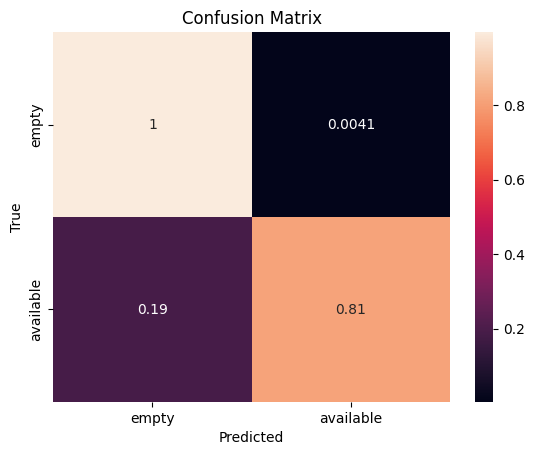

In [47]:
df_cm = pd.DataFrame([[tn_p, fp_p], [fn_p, tp_p]], index = ["empty", "available"], columns = ["empty", "available"])
g = sns.heatmap(df_cm, annot=True)

g.set_xlabel('Predicted')
g.set_ylabel('True')
g.set_title('Confusion Matrix'); 

## Shap values

In [48]:
feature_names = [(col.replace(".0", "").replace("ohe__x0_", "hour").replace("ohe__x1_", "day").replace("ss__x2", "bike_a")
 .replace("ss__x3", "bike_d").replace("ss__x4", "dock_a").replace("ss__x5", "dock_d").replace("ss__x6", "mins"))
 for col in models[0]["columntransformer"].get_feature_names_out()]

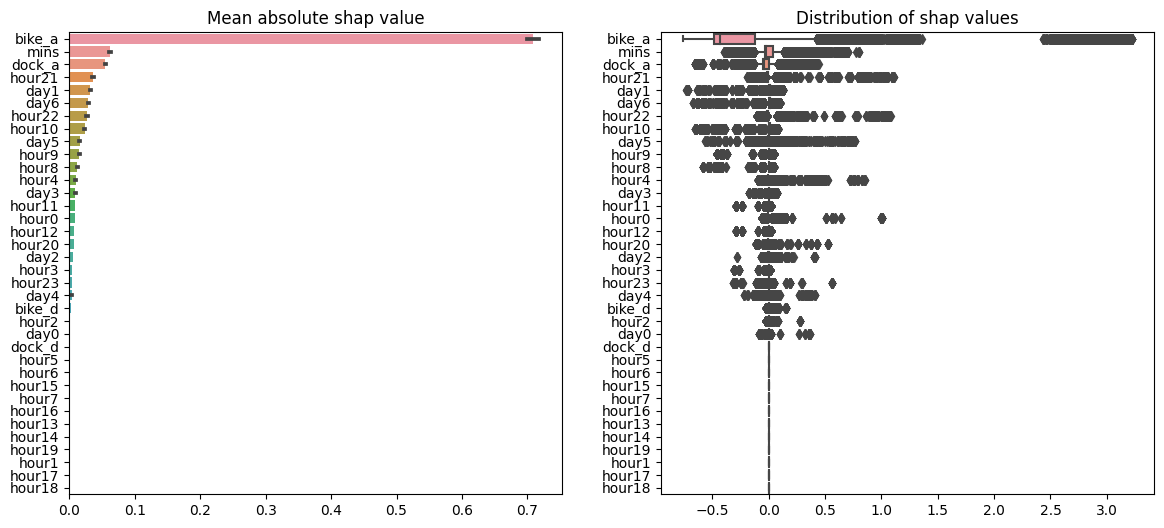

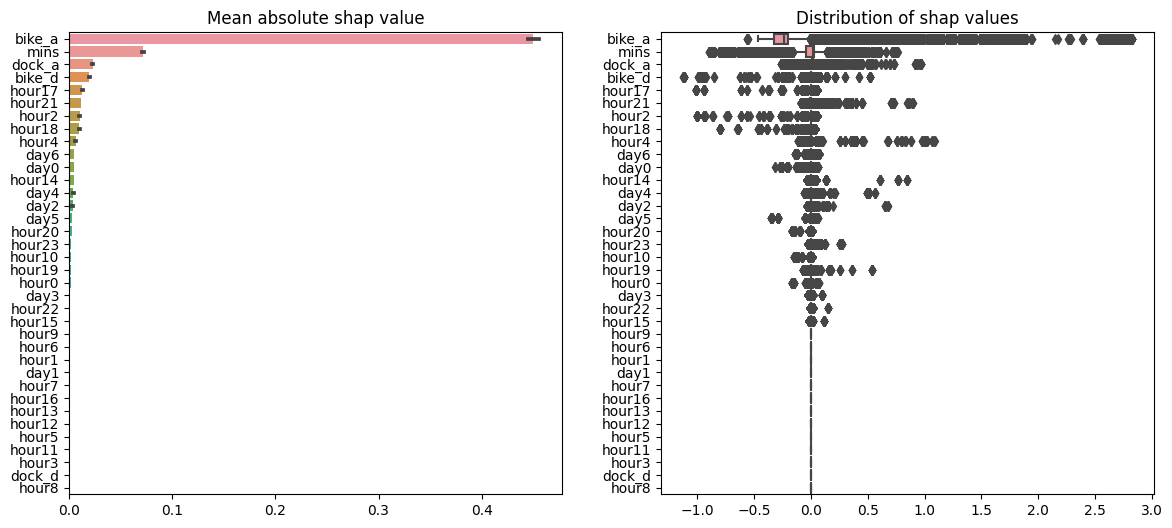

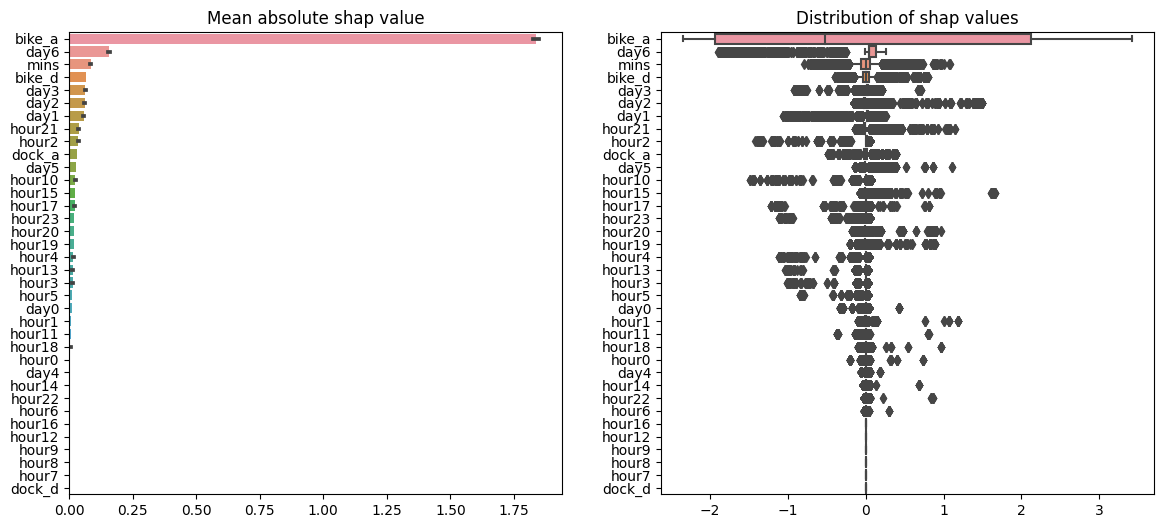

In [49]:
for i in range(len(models)):
    explainer = shap.TreeExplainer(models[i]["lgbmclassifier"], feature_names=feature_names)
    X_test = models[i]["columntransformer"].transform(X_for_test[i])
    shap_values = explainer(X_test)

    # raw look at shap values
    shap_df=pd.DataFrame(shap_values.values[:,:,0], columns=shap_values.feature_names)
    columns = shap_df.apply(np.abs).mean()\
                    .sort_values(ascending=False).index
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
                ax=ax[0])
    ax[0].set_title("Mean absolute shap value")
    sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
    ax[1].set_title("Distribution of shap values");
    plt.show()

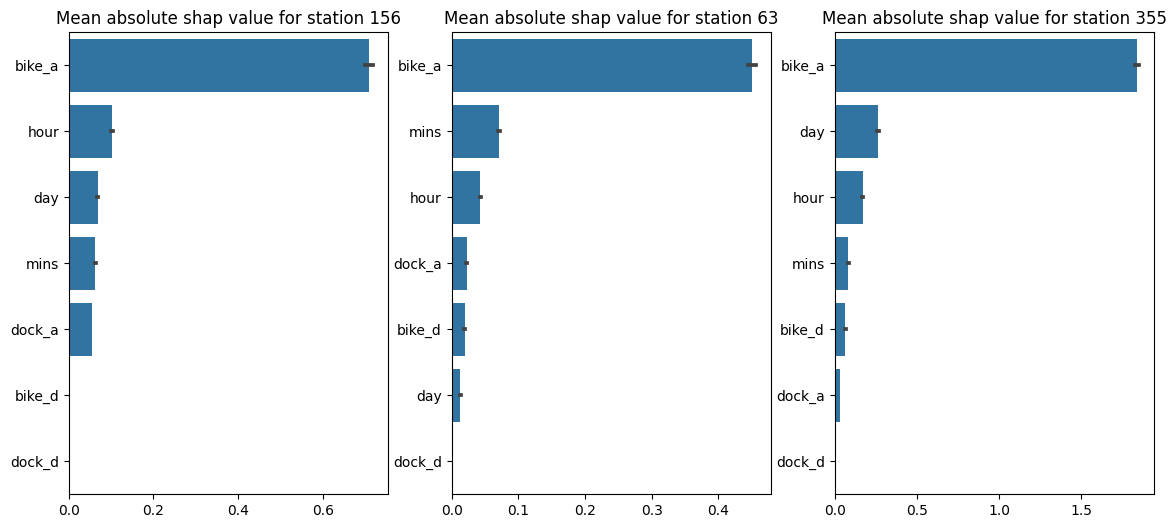

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))
for i in range(3):
    explainer = shap.TreeExplainer(models[i]["lgbmclassifier"], feature_names=feature_names)
    X_test = models[i]["columntransformer"].transform(X_for_test[i])
    shap_values = explainer(X_test)

    new_shap_values = []
    for values in shap_values.values[:,:,0]:
        h = len([1 for c in models[i]["columntransformer"].get_feature_names_out() if c.startswith("ohe__x0")])
        d = len([1 for c in models[i]["columntransformer"].get_feature_names_out() if c.startswith("ohe__x1")])
        values_split = np.split(values , np.cumsum([h,d,1,1,1,1]))    
        values_sum = [sum(l) for l in values_split]
        new_shap_values.append(values_sum)

    # raw look at shap values
    shap_df=pd.DataFrame(new_shap_values, columns=["hour", "day", 'bike_a', 'bike_d', 'dock_a', 'dock_d', 'mins'])
    columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index
    sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', color="tab:blue", ax=ax[i])
    ax[i].set_title(f"Mean absolute shap value for station {stations_for_shap[i]}")